In [1]:
# System & OS
import warnings
warnings.filterwarnings('ignore')
# Data Analysis
import numpy as np
import pandas as pd
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')      # background
plt.rc('figure', titlesize=24)  # figure title 
plt.rc('axes', titlesize=18)    # axes title
plt.rc('axes', labelsize=18)    # xy labels
plt.rc('xtick', labelsize=14)   # x tick labels
plt.rc('ytick', labelsize=14)   # y tick labels
plt.rc('legend', fontsize=14)   # legend
# Utility Functions
from utils import *
# Miscellaneous
from decimal import Decimal
from tqdm.notebook import tqdm

%cd '../data/'
df = pd.read_csv('master_file.csv', skiprows=1, names=['Model number',
                                                       'Class', 
                                                       'Mass ratio', 
                                                       'Timestep', 
                                                       'Inclination', 
                                                       'Wavelength (cm)', 
                                                       'Flux (erg cm^-2 s^-1)', 
                                                       'L_int (Lsun)'])

# Drop irrelevant columns
df.drop(columns=['Timestep', 'Inclination'], inplace=True)
# Typecast objects to float64
df['Mass ratio'] = df['Mass ratio'].apply(lambda x: float(x))
df['L_int (Lsun)'] = df['L_int (Lsun)'].apply(lambda x: float(x))
# Convert wavelengths to microns
df['Wavelength (cm)'] = df['Wavelength (cm)'].apply(lambda x: x * 10000.0)
df.rename(columns={'Wavelength (cm)': 'Wavelength (microns)'}, inplace=True)
# Subdivide class 1 into 1a and 1b
df.loc[df['Mass ratio'] < 0.5, 'Class'] = '0'
df.loc[(df['Mass ratio'] >= 0.5) & (df['Mass ratio'] < 0.75), 'Class'] = '1a'
df.loc[df['Mass ratio'] >= 0.75, 'Class'] = '1b'
# Add columns with logged data
df['log(Flux)'] = np.log10(df['Flux (erg cm^-2 s^-1)'].values)
df['log(L_int)'] = np.log10(df['L_int (Lsun)'].values)
# Drop rows with L_int < 0.1
df = df[df['L_int (Lsun)'] >= 0.1]
# Print number of rows dropped from original dataframe
print(f'Number of rows dropped: {8993600 - len(df)} ({(8993600 - len(df)) / 8993600 * 100:.2f}%)')

# Replace Inf values with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop missing values
df.dropna(axis=0, inplace=True)
# Print number of rows dropped from original dataframe
print(f'Number of rows dropped: {7896500 - len(df)} ({(7896500 - len(df)) / 8993600 * 100:.2f}%)')

/Users/zach/Documents/Projects/Protostellar-Luminosity/data
Number of rows dropped: 1097100 (12.20%)
Number of rows dropped: 140301 (1.56%)


1. Create bootstrapped dataset via sampling w/ replacement
2. Fit model to bootstrapped dataset & generate predictions $P$
3. Repeat steps 1-2 1000’s of times (start with $n=1000$)
4. Compute the variance of $P_i$, for all $i\in n$
5. Plot histogram & check underlying distribution
6. Report mean, std. dev., and confidence intervals

In [94]:
df_70 = df[np.isclose(df['Wavelength (microns)'], 7.35706025e+01)].reset_index(drop=True)
df_70

,Model number,Class,Mass ratio,Wavelength (microns),Flux (erg cm^-2 s^-1),L_int (Lsun),log(Flux),log(L_int)
0,1,0,0.360994,73.570602,2.307951e-09,2.0869,-8.636773,0.319502
1,1,0,0.360994,73.570602,2.301335e-09,2.0869,-8.638020,0.319502
2,1,0,0.360994,73.570602,2.287269e-09,2.0869,-8.640683,0.319502
3,1,0,0.360994,73.570602,2.269262e-09,2.0869,-8.644115,0.319502
4,1,0,0.360994,73.570602,2.238141e-09,2.0869,-8.650112,0.319502
...,...,...,...,...,...,...,...,...
78960,33,1b,0.885142,73.570602,1.296781e-09,5.9644,-8.887133,0.775567
78961,33,1b,0.885142,73.570602,1.225792e-09,5.9644,-8.911583,0.775567
78962,33,1b,0.885142,73.570602,1.107361e-09,5.9644,-8.955711,0.775567
78963,33,1b,0.885142,73.570602,7.349400e-10,5.9644,-9.133748,0.775567


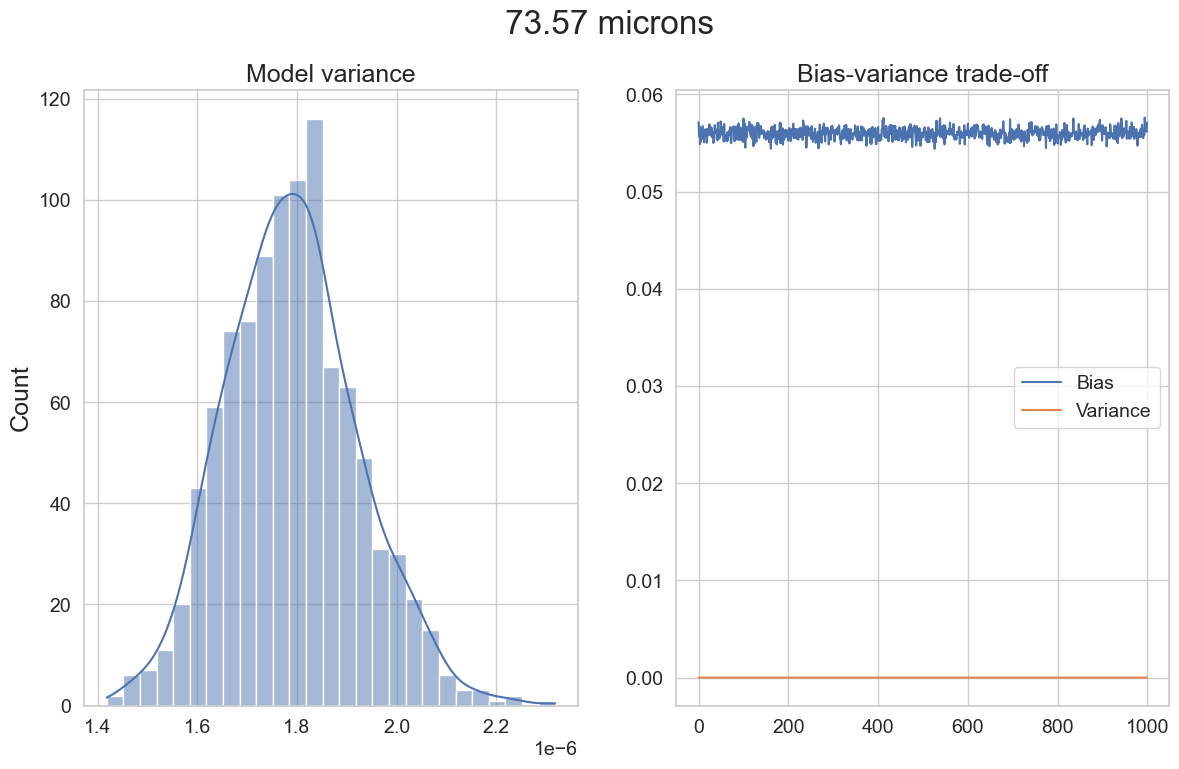

Mean: 1.7906640618326362e-06
Standard deviation: 1.321157283338704e-07
68% Confidence interval: (1.6592805342950206e-06, 1.9220475893702518e-06)
95% Confidence interval: (1.5317219925069723e-06, 2.0496061311583e-06)
99.9% Confidence interval: (1.3559337260995145e-06, 2.225394397565762e-06)


In [92]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mlxtend.evaluate import bias_variance_decomp
from scipy import stats

X, y = np.log10(df_70['L_int (Lsun)'].values), np.log10(df_70['Flux (erg cm^-2 s^-1)'].values)
loss, bias, variance = [], [], []

for i in range(1000):
    # Step 1: Bootstrap via sampling w/ replacement
    # Step 2: Fit model & generate predictions
    # Step 4: Compute model variance
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    X_train, X_test = X_train.reshape(-1, 1), X_test.reshape(-1, 1)

    model = LinearRegression()

    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(model, X_train, y_train, X_test, y_test, loss='mse', random_seed=i)
    loss.append(avg_expected_loss)
    bias.append(avg_bias)
    variance.append(avg_var)

# Step 5: Create histogram & check underlying distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
fig.suptitle('73.57 microns')

sns.histplot(ax=ax[0], data=variance, kde=True)
ax[0].set_title('Model variance')

sns.lineplot(ax=ax[1], data=bias)
sns.lineplot(ax=ax[1], data=variance)
ax[1].set_title('Bias-variance trade-off')
ax[1].legend(['Bias', 'Variance'])

plt.show()

# Step 6: Report mean, std. dev., and confidence intervals 
print(f'Mean: {np.mean(variance)}')
print(f'Standard deviation: {np.std(variance)}')
print(f'68% Confidence interval: {stats.norm.interval(0.68, loc=np.mean(variance), scale=np.std(variance))}')
print(f'95% Confidence interval: {stats.norm.interval(0.95, loc=np.mean(variance), scale=np.std(variance))}')
print(f'99.9% Confidence interval: {stats.norm.interval(0.999, loc=np.mean(variance), scale=np.std(variance))}')

In [98]:
# Dex 
delta = np.log(np.mean(variance) / 2.62 + 10**1) / np.log(10) - 1
delta

2.9682270863418125e-08